In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import os
import sys
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.insert(0, os.path.join(parent_dir, 'pysta2'))

import pysta
import stc
import stcl

# from stcl import load_centers

import pandas as pd
import os

%load_ext autoreload
%autoreload 2

In [22]:
# helper functions for visualization
def box_off():
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def p2p(sta):
    return np.max(sta.ravel()) - np.min(sta.ravel())

def psnr(sta):
    return (np.max(sta.ravel()) - np.min(sta.ravel())) / np.std(sta.ravel())


def plot_spatio_temporal(sta,dt=1000/30, ylabel=None, fig_basename=None):        
    tap = sta.shape[-1]
    figsize = (5.5,3.5)
    plt.figure(figsize=figsize)
    pysta.plot_temporal_profile(sta, tap, dt, ylim=[-0.5,0.5])
    if ylabel is not None:
        plt.ylabel(ylabel)
    print('peak-to-peak diff. = {:.2f}'.format(p2p(sta)))
    print('PSNR = {:.2f}'.format(psnr(sta)))
#     plt.title('peak diff. = {:.2f}'.format(p2p(sta)))
    plt.xlabel(None)

    if fig_basename is not None:
        plt.savefig(fig_basename + '_temp.pdf', bbox_inches='tight') # https://stackoverflow.com/a/4046233

    plt.figure()
    pysta.plot_stim_slices(sta, height=13, width=13, dt=dt, vmin=-0.5, vmax=0.5)

#     plt.tight_layout()
    
    if fig_basename is not None:
        plt.savefig(fig_basename + '_spatial.pdf', bbox_inches='tight')
    
    
def groupby_dict(df, col, group):
    data = dict()
    for group_val, d in df.groupby(group):
#         print(group_val)
        data[group_val] = d[col].to_list()
    return data


def plot_bar_by_group(info, col, 
                      groupby='cell_type', 
                      group_values = ['ON', 'OFF', 'ON-OFF', 'Unknown'], color=['r','#00A0FF','green', '#A0A0A0']):
    
    means = info.groupby(groupby)[col].mean()[group_values]
    sems = info.groupby(groupby)[col].sem()[group_values]

    plt.bar(group_values, means, yerr=sems,
            width=0.4, color=color, edgecolor='k', linewidth=1,
            capsize=5)
    
    plt.ylabel(col)
    plt.xlabel('cell type')

    plt.xlim(-0.5, 3.5)
    box_off()

## load data

In [23]:
data_path = 'data'
dataset = '20201216'
# dataset = '20201209'

info = pd.read_csv(os.path.join(data_path, dataset + '_info.csv'))
data = np.load(os.path.join(data_path, dataset + '.npz'))

stim = data['stim'] - 0.5
spike_counts = data['spike_counts']

len(info)

107

In [4]:
info['cell_type'].value_counts()

Unknown    52
ON         32
OFF        13
ON-OFF     10
Name: cell_type, dtype: int64

In [5]:
idx_unknown = info['cell_type'] == 'ON-OFF'
info[idx_unknown]

,channel,cell_type
10,17c,ON-OFF
23,26a,ON-OFF
24,28a,ON-OFF
25,28b,ON-OFF
30,38a,ON-OFF
43,51b,ON-OFF
54,58a,ON-OFF
55,58b,ON-OFF
88,77a,ON-OFF
105,87a,ON-OFF


## calc STA for an RGC

In [6]:
print(stim.shape)
print(spike_counts.shape)

(27000, 169)
(107, 27000)


In [99]:
# choose a channel

ch_idx = 10  # 17c ON-OFF
ch_idx = 23  # 26a ON-OFF
ch_idx = 24  # 28a ON-OFF


# 26x26
# ch_idx = 2    # 14a ON-OFF
# ch_idx = 22   # 33c	ON
# ch_idx = 29   # 37b ON
# ch_idx = 41     # 48b OFF
# ch_idx = 67     # 71c ON


# small p2p
# ch_idx = 81  #85b ON-OFF
#ch_idx = 84 #87b ON

channel_name = info['channel'][ch_idx]
cell_types = info['cell_type'][ch_idx]
print(channel_name, cell_types)

28a ON-OFF


In [100]:
tap=12
spike_triggered_stim, weights = pysta.grab_spike_triggered_stim(stim, spike_counts[ch_idx], tap=tap)

In [101]:
sta = np.average(spike_triggered_stim, weights=weights, axis=0)
# sta.shape

print(spike_triggered_stim.shape)



# plot_spatio_temporal(sta, ylabel='STA',
#                      fig_basename=os.path.join('figure', 'sta', channel_name))
# plt.title(channel_name + '(%.2f)'.format)

(19473, 169, 12)


In [102]:
# non-centered STC
data_row = spike_triggered_stim.reshape([spike_triggered_stim.shape[0], -1])

num_components=10
eig_values, eig_vectors = stc.do_stc(data_row, weights=weights, num_components=num_components)

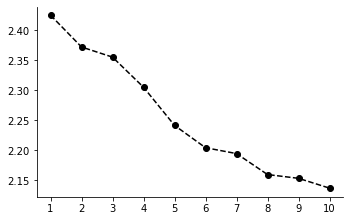

In [103]:
figsize = (5.5,3.5)
plt.figure(figsize=figsize)


counts = 1 + np.array(list(range(num_components)))
plt.plot(counts, eig_values[:num_components], 'o--k')
# plt.ylabel('eigenvalues')
plt.xticks(counts)
box_off()

import os
if not os.path.exists(os.path.join('figure', 'stcl')):
    os.makedirs(os.path.join('figure', 'stcl'))
    
    
plt.savefig(os.path.join('figure', 'stcl', channel_name) + '_nc_eigval.pdf', bbox_inches='tight')

(array([   60.,     0.,     0.,     0.,    60.,   268.,  3407., 14358.,
         1171.,   149.]),
 array([-13.34441633, -11.5375773 ,  -9.73073827,  -7.92389924,
         -6.11706021,  -4.31022118,  -2.50338215,  -0.69654312,
          1.11029591,   2.91713494,   4.72397397]),
 <a list of 10 Patch objects>)

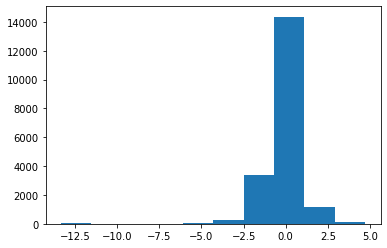

In [104]:
# project
projected = stc.project(data_row, eig_vectors)

plt.hist(projected[:,0])
# plt.hist([projected[:,0], projected[:,1]])

(-14.247835842882663,
 5.6273934854185494,
 -13.264944243635073,
 4.742452142657384)

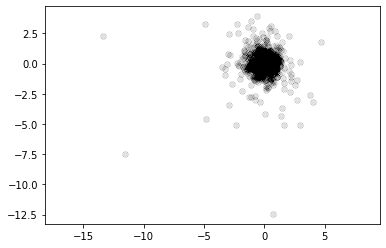

In [105]:
plt.plot(projected[:,0], projected[:,1], 'ok', alpha=0.005)
plt.axis('equal')

In [113]:
# now do clustering
cluster_dim = 2
cl = stcl.fit(projected[:, :cluster_dim], weights)
pred = cl.predict(projected[:, :cluster_dim])

group_centers = stcl.calc_centers(data_row, weights, pred)

In [114]:
weights.shape

(19473,)

In [115]:
# calc inner product of two centers
inner_product = np.dot(group_centers[0].ravel(), group_centers[1].ravel())

# calc PSNRs for the two centers
p2p0, sig0 = pysta.calc_peak_to_peak_and_std(group_centers[0])
p2p1, sig1 = pysta.calc_peak_to_peak_and_std(group_centers[1])

peak-to-peak diff. = 0.45
PSNR = 6.27
peak-to-peak diff. = 0.13
PSNR = 6.24


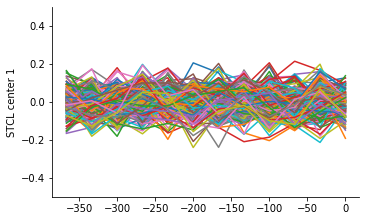

<Figure size 432x288 with 0 Axes>

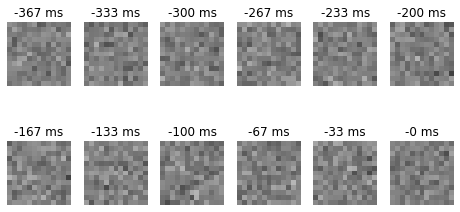

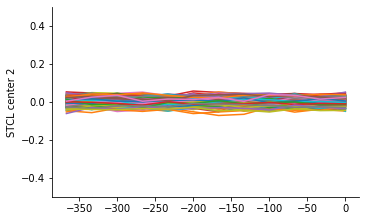

<Figure size 432x288 with 0 Axes>

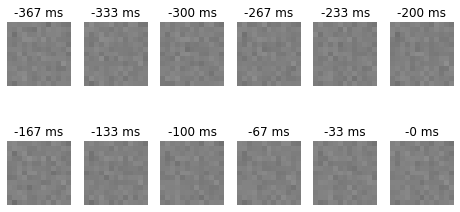

In [116]:
plot_spatio_temporal(group_centers[0].reshape(13*13, -1), ylabel='STCL center 1', 
                     fig_basename=os.path.join('figure', 'stcl', channel_name) + '_center0')

plot_spatio_temporal(group_centers[1].reshape(13*13, -1), ylabel='STCL center 2', 
                     fig_basename=os.path.join('figure', 'stcl', channel_name) + '_center1')

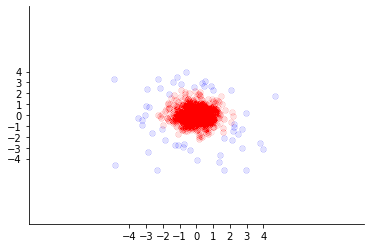

In [110]:
stcl.plot_projection_with_label(projected, pred, 0.003, (-10,10))

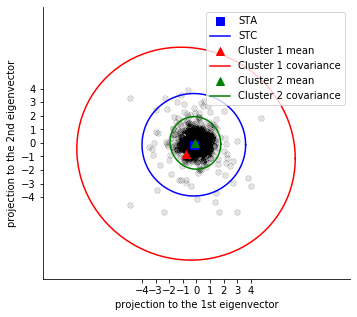

In [111]:
stcl.plot_projection(projected, weights, cl, 0.005, [-10, 10])

In [117]:
cl.covariances_

array([[[10.85193089, -0.4823667 ],
        [-0.4823667 , 10.30325398]],

       [[ 0.58407358, -0.02743534],
        [-0.02743534,  0.62707263]]])

(array([  30.,    0.,    0.,    0.,   30.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,   60.,    0.,    0.,    0.,
          89.,  120.,   59.,  149.,  191.,  423., 1073., 1571., 3309.,
        3463., 3293., 2748., 1545.,  643.,  215.,  169.,   86.,   58.,
          60.,    0.,   30.,   30.,   29.]),
 array([-13.34441633, -12.98304852, -12.62168072, -12.26031291,
        -11.8989451 , -11.5375773 , -11.17620949, -10.81484169,
        -10.45347388, -10.09210607,  -9.73073827,  -9.36937046,
         -9.00800266,  -8.64663485,  -8.28526704,  -7.92389924,
         -7.56253143,  -7.20116363,  -6.83979582,  -6.47842801,
         -6.11706021,  -5.7556924 ,  -5.3943246 ,  -5.03295679,
         -4.67158898,  -4.31022118,  -3.94885337,  -3.58748557,
         -3.22611776,  -2.86474995,  -2.50338215,  -2.14201434,
         -1.78064654,  -1.41927873,  -1.05791093,  -0.69654312,
         -0.33517531,   

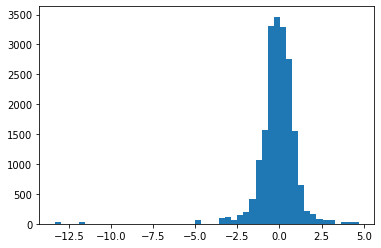

In [124]:
plt.hist(projected[:,0], 50)
# plt.hist(projected[:,1], 50)

*It's peparating the main peak out of noise*

In [45]:
duplicated = []
for idx_row in range(projected.shape[0]):
    row = projected[np.newaxis,idx_row,:]
#     print(row.shape, weights[idx_row])
    duplicated.append(np.repeat(row, weights[idx_row], axis=0))
#     print()
#plt.hist(weights)

np.concatenate(duplicated, axis=0).shape

(4314, 10)

In [46]:
np.sum(weights)

4314

In [49]:
stcl.repeat_row(projected, weights).shape

(4314, 10)

## Choose the cluster 2 and re-run

In [128]:
data_row.shape, pred.shape

((19473, 2028), (19473,))

In [130]:
cl.covariances_

array([[[10.85193089, -0.4823667 ],
        [-0.4823667 , 10.30325398]],

       [[ 0.58407358, -0.02743534],
        [-0.02743534,  0.62707263]]])

(array([ 1534.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 17939.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

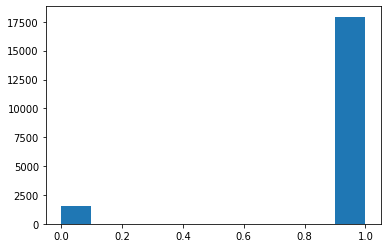

In [132]:
plt.hist(pred)

In [137]:
data_chosen = data_row[pred==1,:]
data_chosen.shape

(17939, 2028)

In [141]:
weights_chosen = weights[pred==1]
print(weights_chosen.shape)

(17939,)


In [142]:
num_components=10
eig_values, eig_vectors = stc.do_stc(data_chosen, weights=weights_chosen, num_components=num_components)

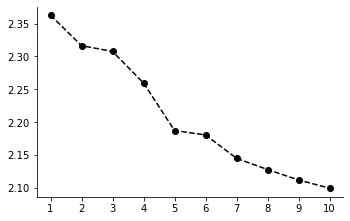

In [143]:
figsize = (5.5,3.5)
plt.figure(figsize=figsize)


counts = 1 + np.array(list(range(num_components)))
plt.plot(counts, eig_values[:num_components], 'o--k')
# plt.ylabel('eigenvalues')
plt.xticks(counts)
box_off()

import os
if not os.path.exists(os.path.join('figure', 'stcl')):
    os.makedirs(os.path.join('figure', 'stcl'))
    
    
plt.savefig(os.path.join('figure', 'stcl', channel_name) + '_nc_eigval.pdf', bbox_inches='tight')

(array([  30.,    0.,    0.,    0.,    0.,    0.,   58.,   88.,   59.,
         294.,  546.,  992., 2409., 3897., 3837., 2089., 2008.,  761.,
         436.,  113.,  115.,   57.,    0.,    0.,   30.,    0.,   30.,
           0.,   30.,    0.,   30.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,   30.]),
 array([-6.07728727, -5.64916535, -5.22104343, -4.79292151, -4.3647996 ,
        -3.93667768, -3.50855576, -3.08043384, -2.65231193, -2.22419001,
        -1.79606809, -1.36794617, -0.93982426, -0.51170234, -0.08358042,
         0.3445415 ,  0.77266341,  1.20078533,  1.62890725,  2.05702917,
         2.48515108,  2.913273  ,  3.34139492,  3.76951684,  4.19763875,
         4.62576067,  5.05388259,  5.48200451,  5.91012642,  6.33824834,
         6.76637026,  7.19449218,  7.62261409,  8.05073601,  8.47885793,
         8.90697985,  9.33510176,  9.76322368, 10.1913456 , 10.61946751,
        11.04758

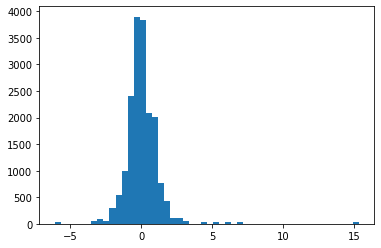

In [146]:
# project
projected = stc.project(data_chosen, eig_vectors)

plt.hist(projected[:,0], 50)
# plt.hist([projected[:,0], projected[:,1]])

(-7.147592060067661, 16.39911340082762, -10.050617783437765, 7.831435245418632)

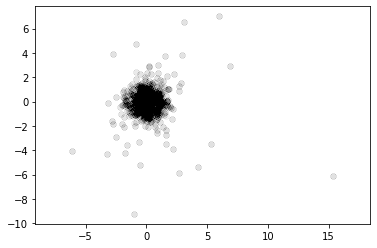

In [147]:
plt.plot(projected[:,0], projected[:,1], 'ok', alpha=0.005)
plt.axis('equal')

In [150]:
# now do clustering
cluster_dim = 2
cl = stcl.fit(projected[:, :cluster_dim], weights_chosen)
pred = cl.predict(projected[:, :cluster_dim])

group_centers = stcl.calc_centers(data_chosen, weights_chosen, pred)

peak-to-peak diff. = 0.14
PSNR = 6.70
peak-to-peak diff. = 0.55
PSNR = 6.16


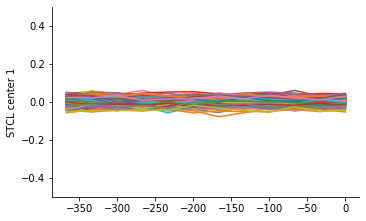

<Figure size 432x288 with 0 Axes>

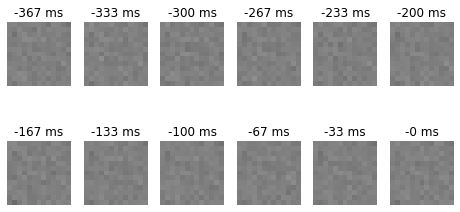

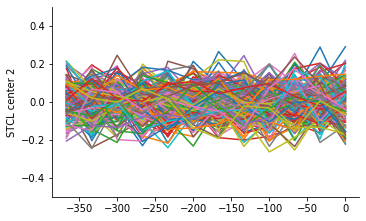

<Figure size 432x288 with 0 Axes>

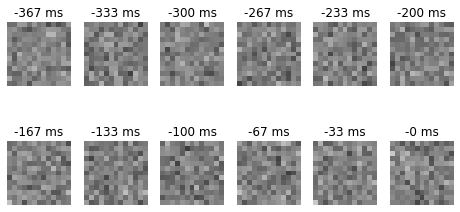

In [151]:
plot_spatio_temporal(group_centers[0].reshape(13*13, -1), ylabel='STCL center 1', 
                     fig_basename=os.path.join('figure', 'stcl', channel_name) + '_center0')

plot_spatio_temporal(group_centers[1].reshape(13*13, -1), ylabel='STCL center 2', 
                     fig_basename=os.path.join('figure', 'stcl', channel_name) + '_center1')

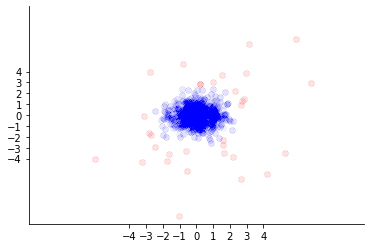

In [152]:
stcl.plot_projection_with_label(projected, pred, 0.003, (-10,10))

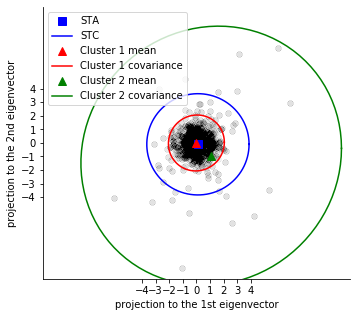

In [154]:
stcl.plot_projection(projected, weights_chosen, cl, 0.005, [-10, 10])

## Run STCL for all RGCs

First, run `run_stcl_batch.py`(offline).
Then, run the following cells for analysis

In [32]:
# idx_on_off = info['cell_type'] == 'ON-OFF'
# channel_names = info[idx_on_off]['channel'].to_list()

p2ps = list()
psnrs = list()
for ch_idx in range(len(info)):
    
    channel_name = info.iloc[ch_idx]['channel']
    
    file_path = os.path.join('results', dataset, channel_name + '.npz')
    print(channel_name)
    
    results = np.load(file_path)
    sta = results['sta'].reshape(26,26,-1)
    center1 = results['group_centers'][0].reshape(26,26,-1)
    center2 = results['group_centers'][1].reshape(26,26,-1)
    
    print(p2p(sta), p2p(center1), p2p(center2))
    p2ps.append([p2p(sta), p2p(center1), p2p(center2)])
    
    print(psnr(sta), psnr(center1), psnr(center2))
    psnrs.append([psnr(sta), psnr(center1), psnr(center2)])
    
    
p2ps = np.array(p2ps)
psnrs = np.array(psnrs)

# save to info
info['sta_p2p'] = p2ps[:,0]
info['center1_p2p'] = p2ps[:,1]
info['center2_p2p'] = p2ps[:,2]

info['sta_psnr'] = psnrs[:,0]
info['center1_psnr'] = psnrs[:,1]
info['center2_psnr'] = psnrs[:,2]

13a
0.12007788836001726 0.11962513781697909 1.0
7.00525155058526 6.952121582784659 6.244258639993106
13b
0.1265443654062149 0.8409961685823755 0.12989568982483768
6.978080427720747 7.411202196092163 7.150768372905994
14a
0.1281219591307169 0.1281219591307169 nan
6.9240265392335045 6.9240265392335045 nan
16a
0.11437630753138078 0.12064883381189867 0.9393010423053342
6.7115263253685935 7.037953436513918 7.418204720835985
17a
0.15014546228624143 0.14755467800729039 0.8389189189189189
7.547576105004577 7.519725183731784 7.130363602376573
21a
0.12388804512909524 0.12430608468488086 1.0
6.7989943995763165 6.8089538670579755 2.9860517923584435
22a
0.17304656669297552 0.8938388625592417 0.1579575869878525
9.249334461229108 7.253734965431863 8.426998484242546
22b
0.1704634108285224 0.15688043299983595 0.8125
9.11616966335015 8.398247141377885 7.1476548942008025
23a
0.13624294722867575 1.0 0.1326577089501253
7.7473862155333295 7.429891753946771 7.519323373040837
23b
0.21107594936708868 0.2110759

In [34]:
info

,channel,cell_type,sta_p2p,center1_p2p,center2_p2p,sta_psnr,center1_psnr,center2_psnr
0,13a,ON,0.120078,0.119625,1.000000,7.005252,6.952122,6.244259
1,13b,ON,0.126544,0.840996,0.129896,6.978080,7.411202,7.150768
2,14a,ON-OFF,0.128122,0.128122,NaN,6.924027,6.924027,NaN
3,16a,Unknown,0.114376,0.120649,0.939301,6.711526,7.037953,7.418205
4,17a,ON-OFF,0.150145,0.147555,0.838919,7.547576,7.519725,7.130364
...,...,...,...,...,...,...,...,...
80,85a,ON-OFF,0.169087,0.169087,NaN,7.878006,7.878006,NaN
81,85b,ON-OFF,0.351080,0.335518,1.000000,10.787246,10.684885,5.959083
82,86a,ON-OFF,0.160101,0.156561,1.000000,7.932275,7.773023,2.780876
83,87a,Unknown,0.238866,0.224035,0.862526,11.859607,11.193089,7.382840


Text(0, 0.5, 'PSNR')

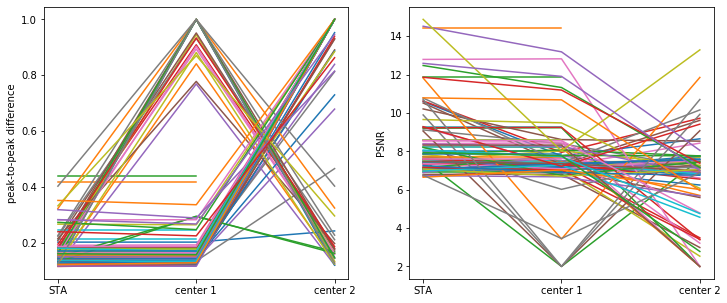

In [37]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(['STA', 'center 1', 'center 2'], p2ps.T)
plt.ylabel('peak-to-peak difference')
plt.subplot(122)
plt.plot(['STA', 'center 1', 'center 2'], psnrs.T)
plt.ylabel('PSNR')

In [35]:
info.to_csv(dataset + '_stcl.csv', index=None)
info

,channel,cell_type,sta_p2p,center1_p2p,center2_p2p,sta_psnr,center1_psnr,center2_psnr
0,13a,ON,0.120078,0.119625,1.000000,7.005252,6.952122,6.244259
1,13b,ON,0.126544,0.840996,0.129896,6.978080,7.411202,7.150768
2,14a,ON-OFF,0.128122,0.128122,NaN,6.924027,6.924027,NaN
3,16a,Unknown,0.114376,0.120649,0.939301,6.711526,7.037953,7.418205
4,17a,ON-OFF,0.150145,0.147555,0.838919,7.547576,7.519725,7.130364
...,...,...,...,...,...,...,...,...
80,85a,ON-OFF,0.169087,0.169087,NaN,7.878006,7.878006,NaN
81,85b,ON-OFF,0.351080,0.335518,1.000000,10.787246,10.684885,5.959083
82,86a,ON-OFF,0.160101,0.156561,1.000000,7.932275,7.773023,2.780876
83,87a,Unknown,0.238866,0.224035,0.862526,11.859607,11.193089,7.382840


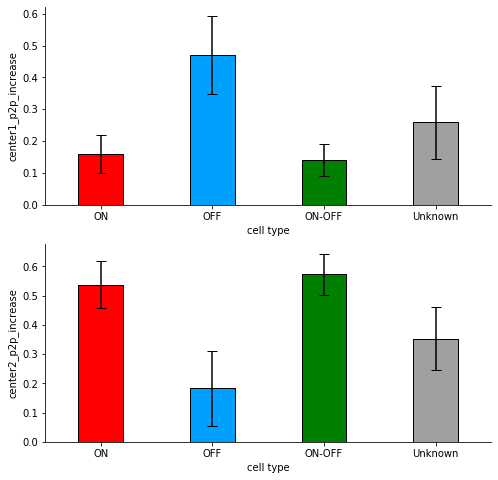

In [66]:
info['center1_p2p_increase'] = info['center1_p2p'] - info['sta_p2p']
info['center2_p2p_increase'] = info['center2_p2p'] - info['sta_p2p']

plt.figure(figsize=(8,8))    
plt.subplot(211)
plot_bar_by_group(info, 'center1_p2p_increase')    
plt.subplot(212)
plot_bar_by_group(info, 'center2_p2p_increase')    
    
plt.savefig("figure/stcl/p2p_increase.pdf", bbox_inches='tight')
plt.savefig("figure/stcl/p2p_increase.png", bbox_inches='tight')

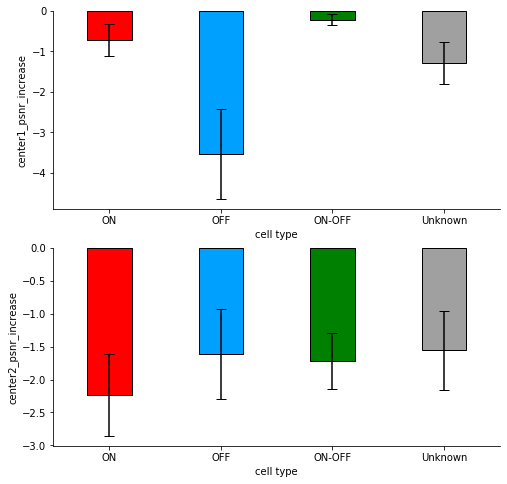

In [65]:
info['center1_psnr_increase'] = info['center1_psnr'] - info['sta_psnr']
info['center2_psnr_increase'] = info['center2_psnr'] - info['sta_psnr']

plt.figure(figsize=(8,8))    
plt.subplot(211)
plot_bar_by_group(info, 'center1_psnr_increase')    
plt.subplot(212)
plot_bar_by_group(info, 'center2_psnr_increase')    
    
plt.savefig("figure/stcl/psnr_increase.pdf", bbox_inches='tight')
plt.savefig("figure/stcl/psnr_increase.png", bbox_inches='tight')